# 1.) Data preprocessing

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import json
import seaborn as sns
import re
from datetime import datetime
from datetime import date

In [2]:
#Ceilometer data
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # interpolate bl_height by time
    df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # aggregate bl_height by hourly average
    df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df

In [3]:
#CTM model data
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [4]:
#WRF model data

data_path = "C:/Users/vichu/Downloads/90106"

wrf_data_path = "//WRF_PBLH"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                      'PBLH_series329_20210218']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})


wrf_df_merriwa['date'] = wrf_df_merriwa.datetime.str[:10]
wrf_df_merriwa['time'] = wrf_df_merriwa.datetime.str[11:13].astype(int)

wrf_df_lidcombe['date'] = wrf_df_lidcombe.datetime.str[:10] 
wrf_df_lidcombe['time'] = wrf_df_lidcombe.datetime.str[11:13].astype(int)



In [5]:
#Converting UTC to AEST

def convert_df_to_datetime_wrf(df):
    df['time_AEST'] = (df['time'] + 10) % 24

    #Loop through and convert date to proper date
    length_data = len(df)

    #Defined new columns
    df['date_proper'] = 0
    df['datetime'] = ''

    #Sets the date based on change of time and creates a datetime stamp
    #Very clunky but it works
    for i in range(length_data):
        date_1 = str(df.loc[i,'date'])

        year_date_1 = date_1[:4]
        month_date_1 = date_1[5:7]
        day_date_1 = int(date_1[8::])

        if i > 1:
            #This means the day has changed
            if (df.loc[i,'time_AEST'] < df.loc[i-1,'time_AEST']):
                day_date_1 += 1

        df.loc[i, 'date_proper'] = date(int(year_date_1), int(month_date_1), day_date_1)

        #Days are monotonic
        if i > 1:
            if (df.loc[i,'date_proper'] < df.loc[i-1,'date_proper']):
                df.loc[i,'date_proper'] = df.loc[i-1,'date_proper']

        date_proper_1 = str(df.loc[i,'date_proper'])
        time_1 = str(df.loc[i, 'time_AEST'])

        datetime_str = date_proper_1 + " " + time_1
        df.loc[i, 'datetime'] = datetime.strptime(datetime_str, '%Y-%m-%d %H')

    df = df[~df.index.duplicated(keep = 'first')]
    
    df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H')
    #Set index to datetime
    df = df.groupby([
        df['datetime'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['datetime'].dt.hour.rename('Hour')
    ])['WRF PBLH'].mean().reset_index(name='WRF_BLH').set_index(['Date', 'Hour'])

    
    return df

In [6]:
wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)

In [7]:
#Combining WRF with CL and CTM model data

import matplotlib.pyplot as plt
%matplotlib inline

def join_CL_CTM_WRF(site, wrf_df):
    CLdf = parse_CL(site)
    CTMdf = parse_CTM(site)
    WRFdf = wrf_df.copy(deep = True)
    
    df_joined = CLdf.join(CTMdf, how='inner')
    
    df_joined = df_joined.join(WRFdf, how = 'inner')
    return df_joined

def bl_plot(site, wrf_df):
    join_df = join_CL_CTM_WRF(site, wrf_df).reset_index()
    join_df['Time'] = pd.to_datetime(join_df[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')
    join_df.plot(x='Time', y=['CL_BLH', 'CTM_BLH', 'WRF_BLH'], title=site)
    plt.show()

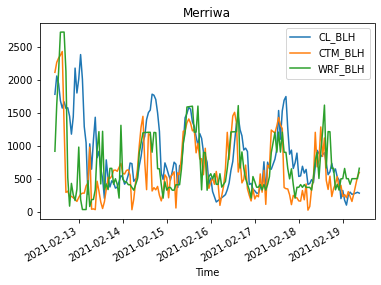

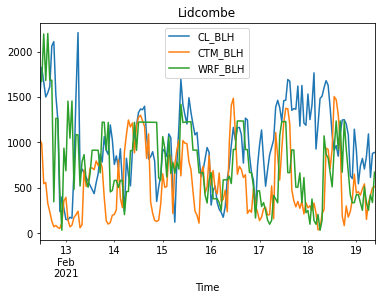

In [8]:
#Plots of Lidcombe and Merriwa BL heights
bl_plot('Merriwa', wrf_df_merriwa)
bl_plot('Lidcombe', wrf_df_lidcombe)

### 1.1 Scraping of air quality data

In [9]:
class AQMS_API:
    def __init__(self):
        self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
        self.headers = {
            'content-type': 'application/json',
            'accept': 'application/json',
        }
        
        self.site_url = 'get_SiteDetails'
        self.parameter_url = 'get_ParameterDetails'
        self.observation_url = 'get_Observations'
        
    def get_data(self, url_suffix, http_method=requests.get, data=None):
        query = self.url_prefix + url_suffix
        response = http_method(url=query, headers=self.headers, json=data)
        return response.json()
    
    def get_sites(self):
        return self.get_data(self.site_url)
    
    def get_parameters(self):
        return self.get_data(self.parameter_url)
    
    def get_observations(self, data=None):
        return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
    '''
    start & end : '%Y-%m-%d' format date string
    '''
    def list_parser(s):
        if s is None or isinstance(s, list):
            return s
        else:
            return [s]

    return {
        'Parameters': list_parser(parameter),
        'Sites': list_parser(sites),
        'StartDate': start,
        'EndDate': end,
        'Categories': list_parser(category),
        'SubCategories': list_parser(sub_category),
        'Frequency': list_parser(freq),
    }

In [10]:
api = AQMS_API()

# site id
sites = {
    'Merriwa': 329,
    'Lidcombe': 1141,
}

In [11]:

df = pd.DataFrame.from_records(api.get_parameters())
params = df.loc[
    (df['Category'] == 'Averages') & 
    (df['SubCategory'] == 'Hourly') & 
    (df['Frequency'] == 'Hourly average')
]

In [12]:
def bl_external(site, site_id):
    query = obs_builder(
        params['ParameterCode'].tolist(), 
        site_id, 
        '2021-02-12',
        '2021-02-20',
        'Averages', 
        'Hourly', 
        'Hourly average'
    )
    obs = pd.DataFrame.from_records(api.get_observations(query))
    obs['Hour'] = obs['Hour'] - 1
    obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
    obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()
    
    if site == 'Merriwa':
        wrf_df = wrf_df_merriwa
    else:
        wrf_df = wrf_df_lidcombe
    
    df = join_CL_CTM_WRF(site, wrf_df).join(obs.set_index(['Date', 'Hour']), how='inner').reset_index()
    df['BL_diff'] =df['CL_BLH'] - df['CTM_BLH'] 
    return df

In [13]:
#Consolidating all the data in a dict
data = {site: bl_external(site, id) for site, id in sites.items()}

In [14]:
data

{'Merriwa':            Date  Hour       CL_BLH    CTM_BLH  WRF_BLH  Carbon monoxide  \
 0    2021-02-12    11  1782.971698  2116.5154   918.04        -0.013024   
 1    2021-02-12    12  2060.904255  2268.4509  1629.29        -0.003834   
 2    2021-02-12    13  1942.894737  2332.6211  2124.96        -0.004704   
 3    2021-02-12    14  1684.731183  2376.4629  2726.00        -0.003592   
 4    2021-02-12    15  1573.967391  2432.8503  2727.78        -0.002880   
 ..          ...   ...          ...        ...      ...              ...   
 161  2021-02-19     5   264.802803   156.5146   501.85        -0.033830   
 162  2021-02-19     6   271.336676   271.2063   501.62        -0.035252   
 163  2021-02-19     7   283.446311   402.5884   502.13        -0.032138   
 164  2021-02-19     8   295.176486   530.2465   503.18        -0.027304   
 165  2021-02-19     9   282.303491   596.1211   659.98        -0.031719   
 
      Humidity  Nephelometer   Nitric Oxide  Nitrogen Dioxide     Ozone  \


# 2.) Correlation analysis and statistical metrics

### 2.1 Correlation analysis

In [15]:
#Calculating correlation and p-values for the features w.r.t the BL height

def get_df(site):
    if site == 'all':
        df = pd.concat(data.values()).drop(columns='Solar radiation')
    else:
        df = data[site]
    return df.dropna().set_index(['Date', 'Hour'])

def corr(site, method='pearson'):
    return get_df(site).corr(method=method)

from scipy.stats import pearsonr

def p_value(site):
    df = get_df(site)._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [16]:
#Combining Lidcombe and Merriwa
corr('all', 'pearson').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,1.000000,0.287952,0.421003
CTM_BLH,0.287952,1.000000,0.533182
WRF_BLH,0.421003,0.533182,1.000000
Carbon monoxide,0.092702,-0.184646,0.071361
Humidity,-0.667230,-0.518442,-0.615021
Nephelometer,0.006918,-0.173402,-0.085122
Nitric Oxide,0.144480,-0.125607,-0.188269
Nitrogen Dioxide,0.011283,-0.424918,-0.286374
Ozone,0.468203,0.455442,0.619387
PM10,0.352813,-0.023971,0.139337


In [17]:
p_value('all').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,0,1e-06,0
CTM_BLH,1e-06,0,0
WRF_BLH,0,0,0
Carbon monoxide,0.125132,0.002108,0.238198
Humidity,0,0,0
Nephelometer,0.909081,0.003923,0.159214
Nitric Oxide,0.016502,0.037367,0.001713
Nitrogen Dioxide,0.852237,0,1e-06
Ozone,0,0,0
PM10,0,0.692281,0.02081


In [18]:
corr('Lidcombe', 'pearson').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,1.000000,0.136481,0.280939
CTM_BLH,0.136481,1.000000,0.240733
WRF_BLH,0.280939,0.240733,1.000000
Carbon monoxide,-0.284860,-0.460941,-0.024760
Humidity,-0.576953,-0.437755,-0.520178
Nephelometer,-0.313251,-0.311381,-0.368367
Nitric Oxide,0.152507,-0.249707,-0.405554
Nitrogen Dioxide,-0.013995,-0.600630,-0.427132
Ozone,0.328640,0.399086,0.712369
PM10,0.138696,-0.119004,0.038611


In [19]:
p_value('Lidcombe').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,0,0.140567,0.002059
CTM_BLH,0.140567,0,0.008641
WRF_BLH,0.002059,0.008641,0
Carbon monoxide,0.001769,0,0.790133
Humidity,0,1e-06,0
Nephelometer,0.000553,0.000599,4.1e-05
Nitric Oxide,0.099213,0.006392,5e-06
Nitrogen Dioxide,0.880438,0,1e-06
Ozone,0.00028,8e-06,0
PM10,0.134177,0.19931,0.678058


In [20]:
corr('Merriwa', 'pearson').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,1.000000,0.395865,0.496932
CTM_BLH,0.395865,1.000000,0.701255
WRF_BLH,0.496932,0.701255,1.000000
Carbon monoxide,0.522859,0.200391,0.354947
Humidity,-0.755757,-0.597379,-0.697415
Nephelometer,-0.128754,-0.089435,-0.041753
Nitric Oxide,0.052930,0.150851,0.130233
Nitrogen Dioxide,-0.104132,-0.312676,-0.256490
Ozone,0.695825,0.497777,0.627332
PM10,0.475645,0.091247,0.202267


In [21]:
p_value('Merriwa').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,0,0,0
CTM_BLH,0,0,0
WRF_BLH,0,0,0
Carbon monoxide,0,0.011856,5e-06
Humidity,0,0,0
Nephelometer,0.108036,0.265323,0.603615
Nitric Oxide,0.510299,0.059313,0.104013
Nitrogen Dioxide,0.194331,6.7e-05,0.001185
Ozone,0,0,0
PM10,0,0.255725,0.011071


### 2.2 Statistical metrics

In [22]:
#Get data from dict
df_merriwa = data['Merriwa']
df_lidcombe = data['Lidcombe']

#checking everything in place
#df_merriwa.shape

In [23]:
#Interpolating missing values by time
def interpolate_external_factors(df):

    df['datetime'] = pd.to_datetime(df['Date'] +' '+ df['Hour'].astype(str)+':00', format = '%Y-%m-%d %H:%M')

    feature_list_all = [feature for feature in df.columns][4:len(df.columns)-2]

    for feature in feature_list_all:
        df[feature] = df.set_index('datetime')[feature].interpolate(method='time').values
        
    return df

In [24]:
df_merriwa_filled = interpolate_external_factors(df_merriwa)
df_lidcombe_filled = interpolate_external_factors(df_lidcombe)

In [25]:
#Creates functions with lags and differences up to d
def create_data_lags(df, d):
    
    df_func = df.copy(deep = True)

    for i in range(d):
        col_name = 'CL_BLH_lag'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].shift(i+1)

    #Double for loop not the best - but want to keep factors at different locations to each other to easier view
    for i in range(d):
        col_name = 'temp'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].diff(periods = i+1)
  
    for i in range(d):
        col_name = 'CL_BLH_diff' + str(i+1)
        target_col = 'temp'+str(i+1)
        df_func[col_name] = df_func[target_col].shift(1)
    
    to_drop_list = ['temp1','temp2','temp3','temp4','temp5']
        
    df_func = df_func.drop(to_drop_list, axis = 1)
        
    return df_func

In [26]:
df_merriwa_wlags = create_data_lags(df_merriwa_filled, 5)
df_lidcombe_wlags = create_data_lags(df_lidcombe_filled, 5)

In [27]:
df_merriwa_wlags.head(10)

,Date,Hour,CL_BLH,CTM_BLH,WRF_BLH,Carbon monoxide,Humidity,Nephelometer,Nitric Oxide,Nitrogen Dioxide,...,CL_BLH_lag1,CL_BLH_lag2,CL_BLH_lag3,CL_BLH_lag4,CL_BLH_lag5,CL_BLH_diff1,CL_BLH_diff2,CL_BLH_diff3,CL_BLH_diff4,CL_BLH_diff5
0,2021-02-12,11,1782.971698,2116.5154,918.04,-0.013024,47.927,0.042,-0.023461,0.069158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-12,12,2060.904255,2268.4509,1629.29,-0.003834,46.820,0.051,-0.015987,0.076345,...,1782.971698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-12,13,1942.894737,2332.6211,2124.96,-0.004704,45.996,0.058,-0.011745,0.066663,...,2060.904255,1782.971698,NaN,NaN,NaN,277.932557,NaN,NaN,NaN,NaN
3,2021-02-12,14,1684.731183,2376.4629,2726.00,-0.003592,44.181,0.060,-0.026188,0.057879,...,1942.894737,2060.904255,1782.971698,NaN,NaN,-118.009518,159.923039,NaN,NaN,NaN
4,2021-02-12,15,1573.967391,2432.8503,2727.78,-0.002880,43.716,0.065,-0.021037,0.052190,...,1684.731183,1942.894737,2060.904255,1782.971698,NaN,-258.163554,-376.173073,-98.240515,NaN,NaN
5,2021-02-12,16,1668.378378,1316.0260,2727.64,0.004235,46.238,0.068,-0.020734,0.047798,...,1573.967391,1684.731183,1942.894737,2060.904255,1782.971698,-110.763791,-368.927346,-486.936864,-209.004307,NaN
6,2021-02-12,17,1569.719626,293.4471,2132.87,0.002853,48.946,0.070,-0.019623,0.053188,...,1668.378378,1573.967391,1684.731183,1942.894737,2060.904255,94.410987,-16.352804,-274.516358,-392.525877,-114.593320
7,2021-02-12,18,1578.604651,312.8919,518.45,-0.002314,52.111,0.068,-0.030633,0.068659,...,1569.719626,1668.378378,1573.967391,1684.731183,1942.894737,-98.658752,-4.247765,-115.011557,-373.175111,-491.184629
8,2021-02-12,19,1450.186706,232.0443,85.15,-0.011205,54.351,0.067,-0.026087,0.074348,...,1578.604651,1569.719626,1668.378378,1573.967391,1684.731183,8.885025,-89.773727,4.637260,-106.126532,-364.290086
9,2021-02-12,20,1178.113208,234.0902,430.46,-0.014778,56.331,0.065,-0.027401,0.083431,...,1450.186706,1578.604651,1569.719626,1668.378378,1573.967391,-128.417945,-119.532920,-218.191672,-123.780685,-234.544476


In [28]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score

In [29]:
#From: https://github.com/rkawsar/ambhas/blob/master/ambhas/errlib.py

#Index of agreement(model prediction error)


def index_agreement(s, o):
    """
    Willmott index of agreement

    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

In [30]:
#mean bias error

def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

In [31]:
def MASE(training_series, testing_series, prediction_series):

    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [32]:
#DTW distance(Dynamic Time Warping)
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def DTW_dist(y_true, y_pred):
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

In [33]:
#Function to calculate and print out metrics

def statistical_metrics_on_df(y_true, y_pred, train_series, location):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(train_series, y_pred, y_true)
    
    print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f\nMASE:%.5f' % (location, ioa, rmse, mae, mbe, dtw_dist, mase))

In [34]:
statistical_metrics_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa CTM model')

At Merriwa CTM model
Index of agreement:0.83320
Root mean squared error:212.95909
Mean absoluate error:171.77558
Mean bias error:-21.58962
DTW distance:3611.44
MASE:0.90875


In [35]:
statistical_metrics_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe CTM model')

At Lidcombe CTM model
Index of agreement:0.39774
Root mean squared error:585.35820
Mean absoluate error:505.07921
Mean bias error:-375.16142
DTW distance:8749.96
MASE:2.29637


In [36]:
statistical_metrics_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa WRF model')

At Merriwa WRF model
Index of agreement:0.64988
Root mean squared error:333.80451
Mean absoluate error:274.93361
Mean bias error:180.78693
DTW distance:5847.39
MASE:1.45449


In [37]:
statistical_metrics_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe WRF model')

At Lidcombe WRF model
Index of agreement:0.53857
Root mean squared error:458.91711
Mean absoluate error:384.71552
Mean bias error:-343.37658
DTW distance:7725.26
MASE:1.74913


# 3.) Regression models

### 3.1.1 Train test split and consideration of all features

In [38]:
feature_list_all = [feature for feature in df_merriwa.columns][5:len(df_merriwa.columns)-2]

In [39]:
#list of all features 
feature_list_all

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ']

In [40]:
#Feature list with lags
feature_list_all_wlags = feature_list_all.copy()

feature_list_all_wlags.extend(['CL_BLH_lag1', 'CL_BLH_lag2','CL_BLH_lag3','CL_BLH_lag4','CL_BLH_lag5'])

feature_list_all_wlags

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ',
 'CL_BLH_lag1',
 'CL_BLH_lag2',
 'CL_BLH_lag3',
 'CL_BLH_lag4',
 'CL_BLH_lag5']

### 3.1.2 Plots

In [41]:
def pred_plots(df, title):
    resid_plot_title = 'Residual plots at '+ title
    pred_plot_title = 'Comparison of predicted BLH at ' + title
    
    sns.set_theme(style="whitegrid")

    # Make an example dataset with y ~ x
    x = df['CL_BLH']
    y = df['Predicted BLH']
    z = df['WRF_BLH']
    # Plot the residuals after fitting a linear model
    sns.residplot(x=x, y=y, lowess=True, color="g").set(title = resid_plot_title)
    df.plot(title = pred_plot_title, figsize=(15,10))
    #df.plot(x=x, y=z, color ="r").set(title = pred_plot_title)

### 3.1.3 Statistical metrics result

In [42]:
def results_print(df, train_series, title):
    pred_plots(df, title)
    statistical_metrics_on_df(df['CL_BLH'], df['Predicted BLH'], train_series, title)

## 3.2 Random forest 

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
def rf_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    #Predict
    
    rf_predict = rf.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  rf_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, rf

In [45]:
#Finding the important features 
def feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.feature_importances_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa RF all features with lags
Index of agreement:0.81466
Root mean squared error:195.41926
Mean absoluate error:164.86028
Mean bias error:141.67130
DTW distance:2592.21
MASE:0.87217


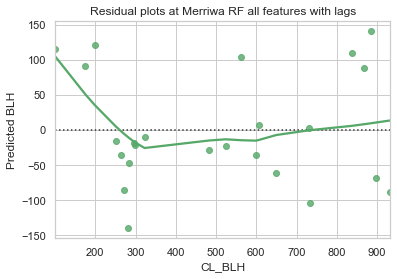

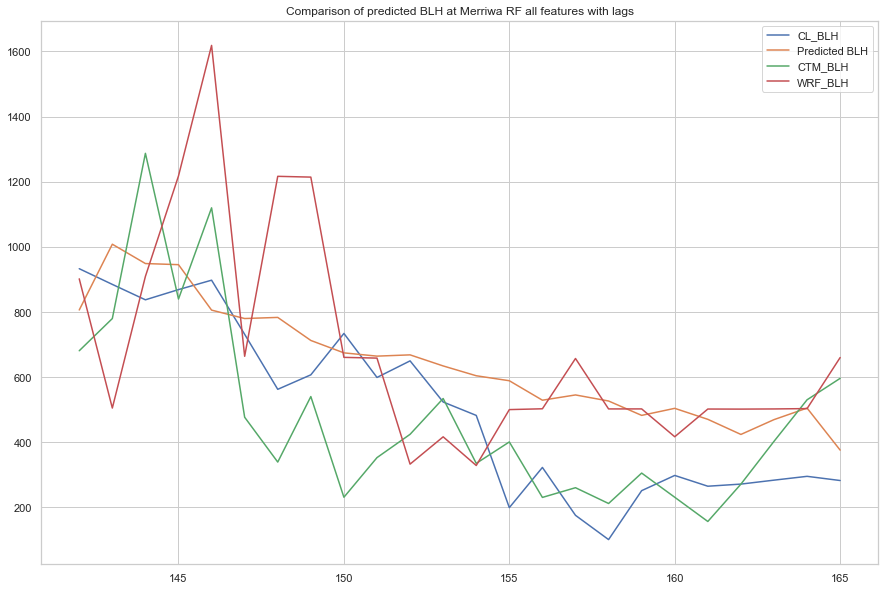

In [46]:
df_rf_merriwa_wlags, rf_merriwa_wlags = rf_modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH')
results_print(df_rf_merriwa_wlags, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa RF all features with lags')

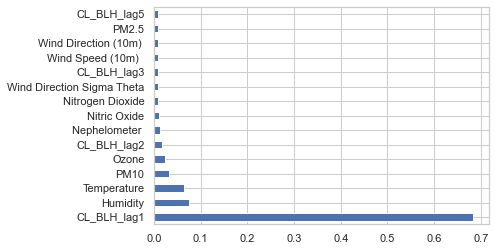

In [47]:
feature_importance_plot(rf_merriwa_wlags, feature_list_all_wlags)

At Lidcombe RF all features with lags
Index of agreement:0.73726
Root mean squared error:246.79368
Mean absoluate error:201.93188
Mean bias error:74.64891
DTW distance:2170.79
MASE:0.91809


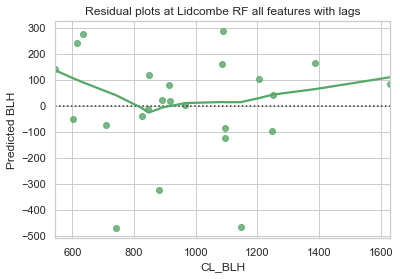

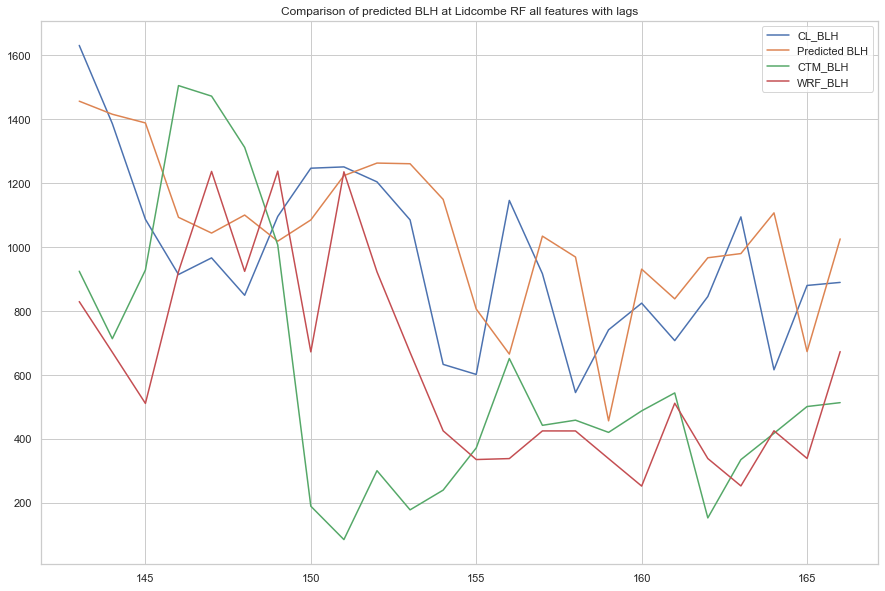

In [48]:
df_rf_lidcombe_wlags, rf_lidcombe_wlags = rf_modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH')
results_print(df_rf_lidcombe_wlags, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe RF all features with lags')

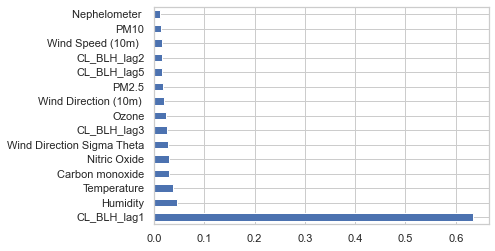

In [49]:
feature_importance_plot(rf_lidcombe_wlags, feature_list_all_wlags)

## 3.3 SVR 

In [50]:
from sklearn import svm

In [51]:
def svm_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    vreg = svm.LinearSVR()
    vreg.fit(X_train, y_train)
    
    #Predict
    
    vreg_predict = vreg.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  vreg_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, vreg

In [52]:
#Finding the important features for SVR
def svm_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


At Merriwa SVR all features with lags
Index of agreement:0.92701
Root mean squared error:140.51500
Mean absoluate error:117.18783
Mean bias error:85.12847
DTW distance:1349.82
MASE:0.61996


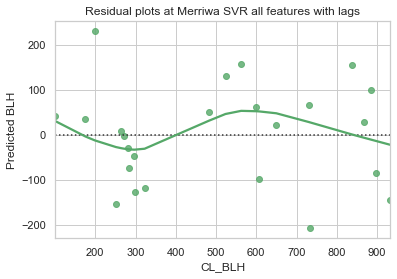

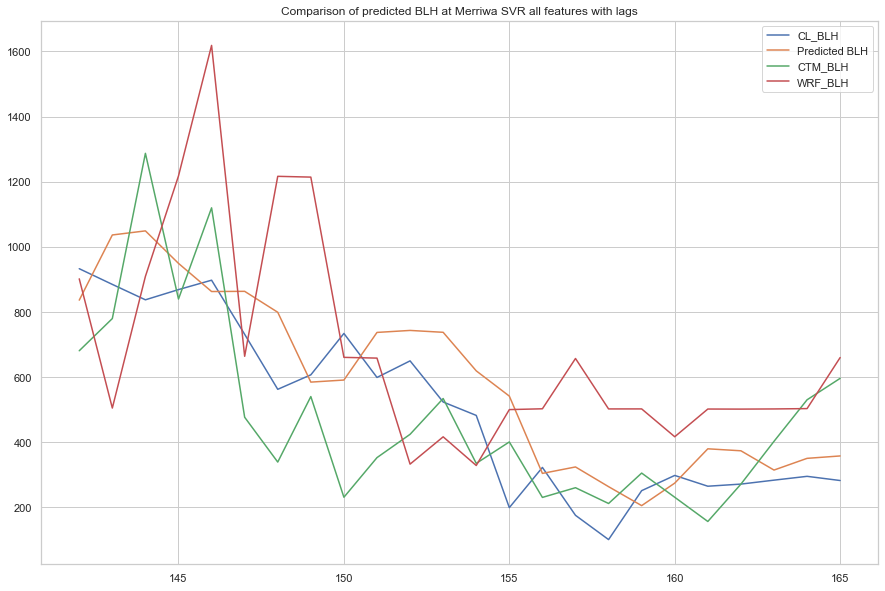

In [53]:
df_vreg_merriwa_wlags, vreg_merriwa_wlags = svm_modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH')
results_print(df_vreg_merriwa_wlags, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa SVR all features with lags')

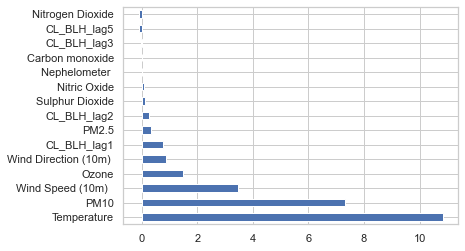

In [54]:
svm_feature_importance_plot(vreg_merriwa_wlags, feature_list_all_wlags)

At Lidcombe SVR all features with lags
Index of agreement:0.67530
Root mean squared error:321.27757
Mean absoluate error:244.46207
Mean bias error:221.75126
DTW distance:3682.60
MASE:1.11146


C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


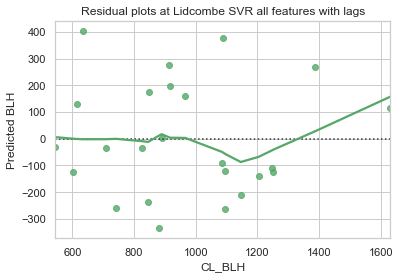

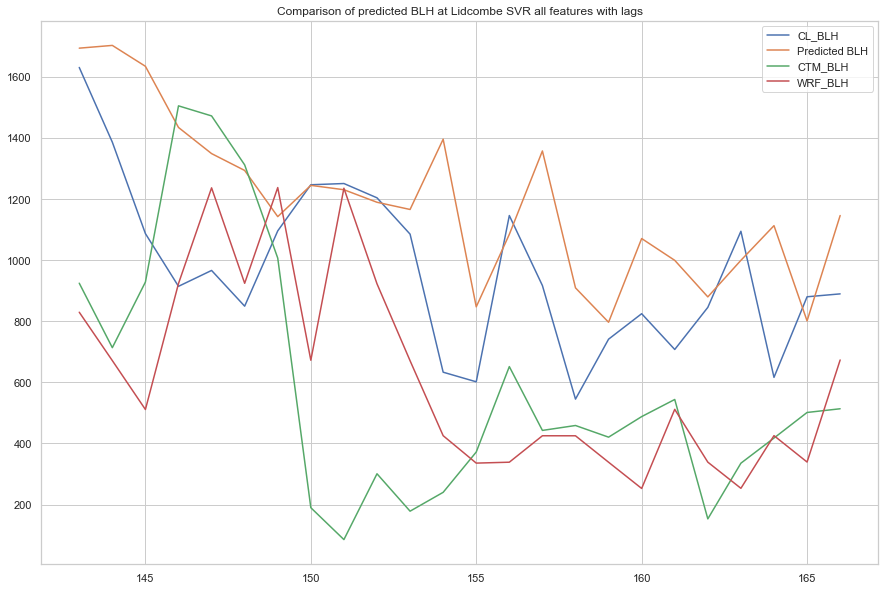

In [55]:
df_vreg_lidcombe_wlags, vreg_lidcombe_wlags = svm_modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH')
results_print(df_vreg_lidcombe_wlags, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe SVR all features with lags')

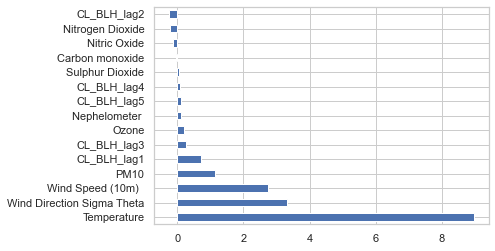

In [56]:
svm_feature_importance_plot(vreg_lidcombe_wlags, feature_list_all_wlags)

## 3.3 Multiple linear regression 

In [57]:
from sklearn.linear_model import LinearRegression
#from matplotlib import pyplot

In [58]:
def mulin_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    mulin = LinearRegression()
    mulin.fit(X_train, y_train)
    
    #Predict
    
    mulin_predict = mulin.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  mulin_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, mulin

In [59]:
#Finding the important features for multiple linear regression
def mulin_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa MLR all features with lags
Index of agreement:0.85626
Root mean squared error:170.09201
Mean absoluate error:137.66580
Mean bias error:107.67741
DTW distance:1981.63
MASE:0.72830


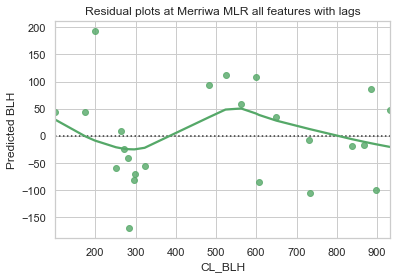

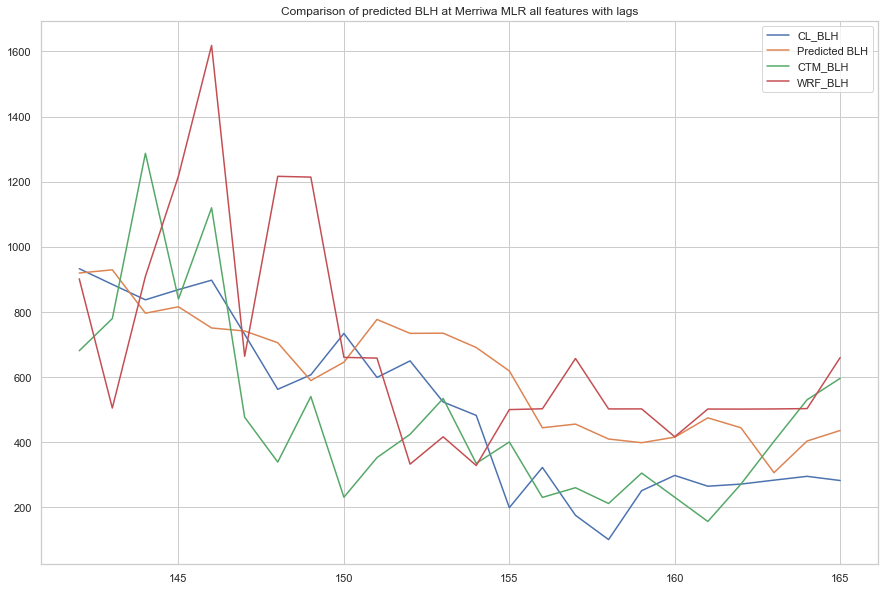

In [60]:
df_mulin_merriwa_wlags, mulin_merriwa_wlags = mulin_modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH')
results_print(df_mulin_merriwa_wlags, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa MLR all features with lags')

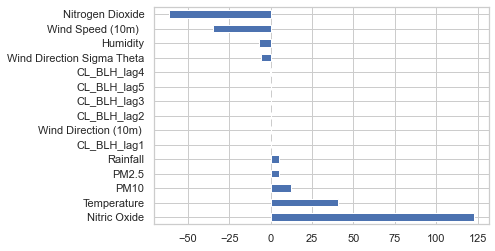

In [61]:
mulin_feature_importance_plot(mulin_merriwa_wlags, feature_list_all_wlags)

At Lidcombe MLR all features with lags
Index of agreement:0.64465
Root mean squared error:251.31426
Mean absoluate error:198.58010
Mean bias error:79.93563
DTW distance:3027.66
MASE:0.90286


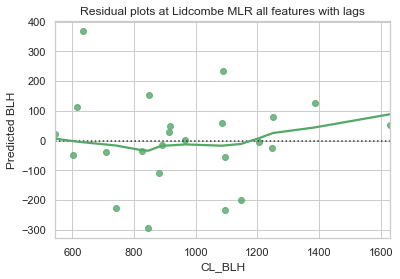

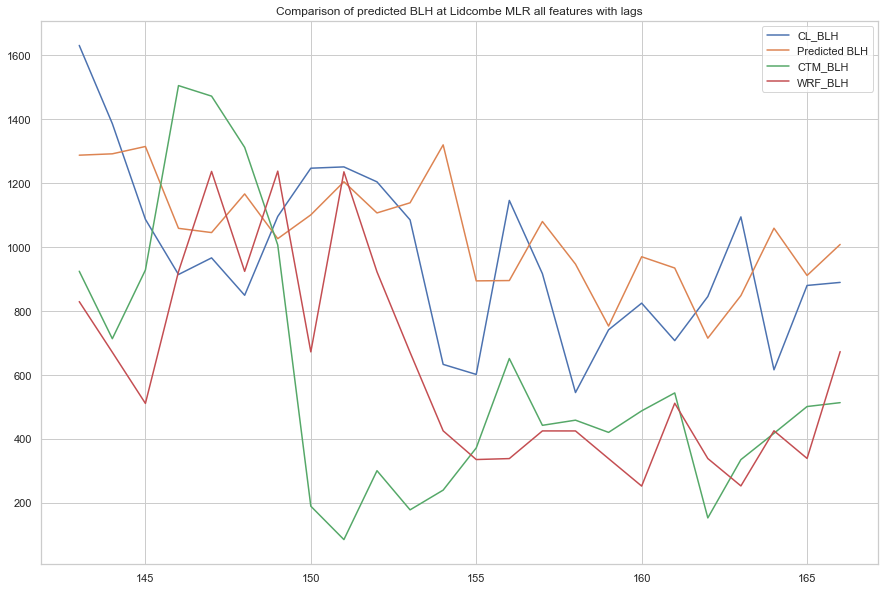

In [62]:
df_mulin_lidcombe_wlags, mulin_lidcombe_wlags = mulin_modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH') 
results_print(df_mulin_lidcombe_wlags, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe MLR all features with lags')

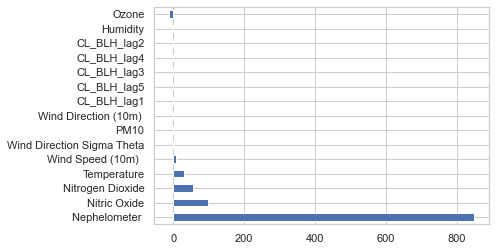

In [63]:
mulin_feature_importance_plot(mulin_lidcombe_wlags, feature_list_all_wlags)

## 3.4 Decision tree 

In [64]:
from sklearn.tree import DecisionTreeRegressor

In [65]:
def tree_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    dtree = DecisionTreeRegressor()
    dtree.fit(X_train, y_train)
    
    #Predict
    
    dtree_predict = dtree.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  dtree_predict
    df_result['CTM_BLH'] = test['CTM_BLH']
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, dtree

In [66]:
#Finding the important features for Decision Tree regression
def dtree_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.feature_importances_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa Decision Tree all features with lags
Index of agreement:0.82398
Root mean squared error:195.52903
Mean absoluate error:161.25877
Mean bias error:74.96301
DTW distance:2684.70
MASE:0.85312


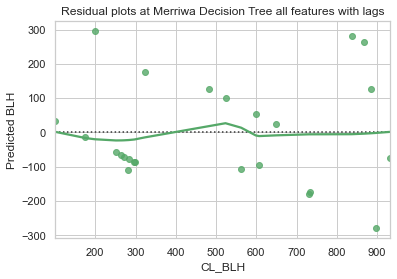

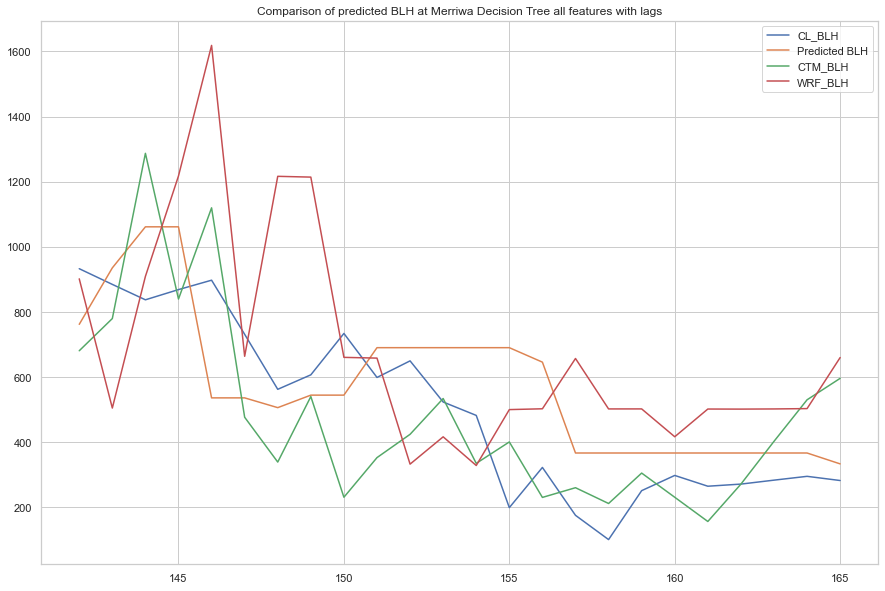

In [67]:
df_dtree_merriwa_wlags, dtree_merriwa_wlags = tree_modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH')
results_print(df_dtree_merriwa_wlags, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Decision Tree all features with lags')

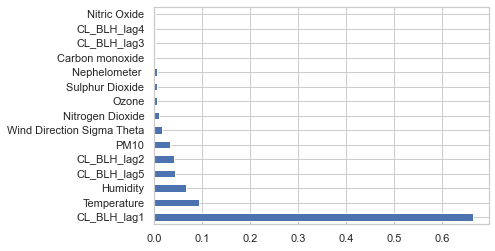

In [68]:
dtree_feature_importance_plot(dtree_merriwa_wlags, feature_list_all_wlags)

At Lidcombe Decision Tree all features with lags
Index of agreement:0.42695
Root mean squared error:425.47783
Mean absoluate error:339.59564
Mean bias error:53.37078
DTW distance:5867.64
MASE:1.54399


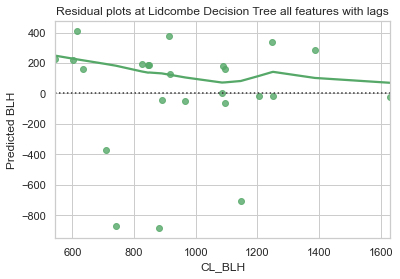

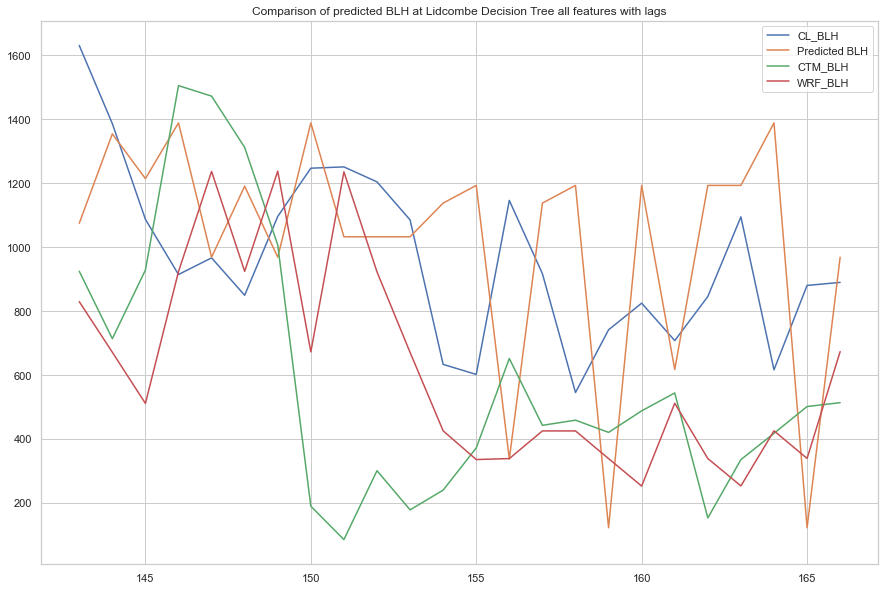

In [69]:
df_dtree_lidcombe_wlags, dtree_lidcombe_wlags = tree_modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH') 
results_print(df_dtree_lidcombe_wlags, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Decision Tree all features with lags')

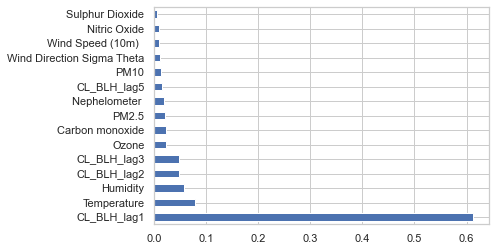

In [70]:
dtree_feature_importance_plot(dtree_lidcombe_wlags, feature_list_all_wlags)

## 3.5 Lasso regression 

In [71]:
from sklearn.linear_model import Lasso

In [72]:
def lasso_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    lasso = Lasso()
    lasso.fit(X_train, y_train)
    
    #Predict
    
    lasso_predict = lasso.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  lasso_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, lasso

In [73]:
#Finding the important features for Lasso regression
def lasso_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa Lasso all features with lags
Index of agreement:0.82389
Root mean squared error:199.35930
Mean absoluate error:172.29641
Mean bias error:158.19850
DTW distance:2564.84
MASE:0.91151


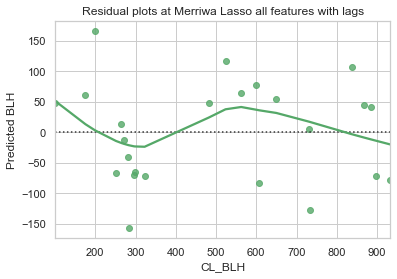

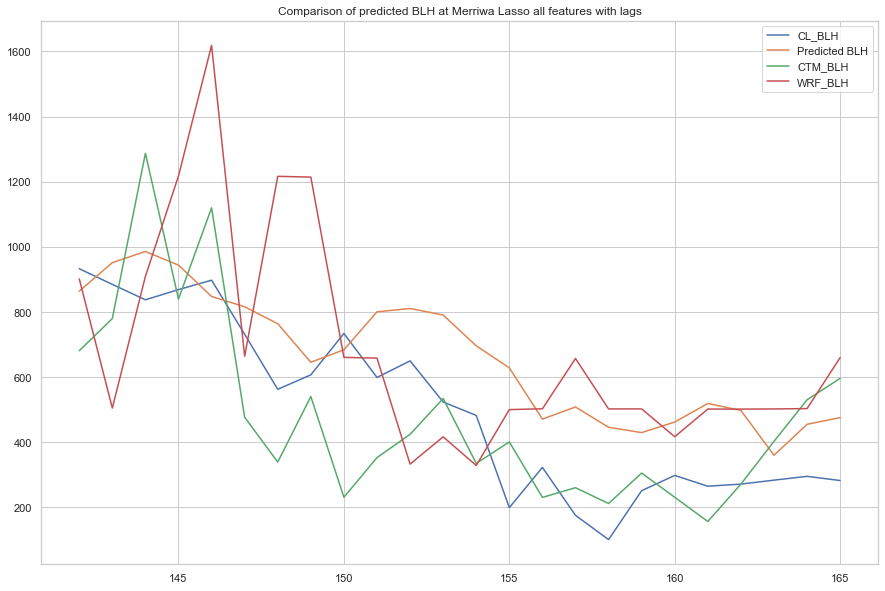

In [74]:
df_lasso_merriwa_wlags, lasso_merriwa_wlags = lasso_modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH')
results_print(df_lasso_merriwa_wlags, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Lasso all features with lags')

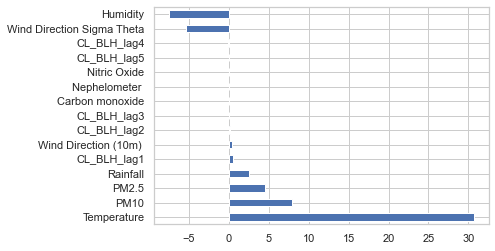

In [75]:
lasso_feature_importance_plot(lasso_merriwa_wlags, feature_list_all_wlags)

At Lidcombe Lasso all features with lags
Index of agreement:0.72735
Root mean squared error:238.68409
Mean absoluate error:190.69622
Mean bias error:-24.10365
DTW distance:2581.24
MASE:0.86701


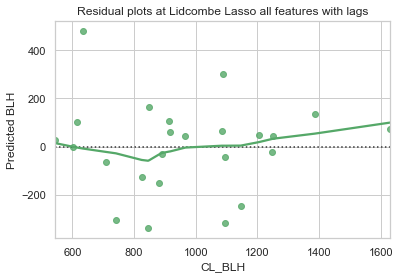

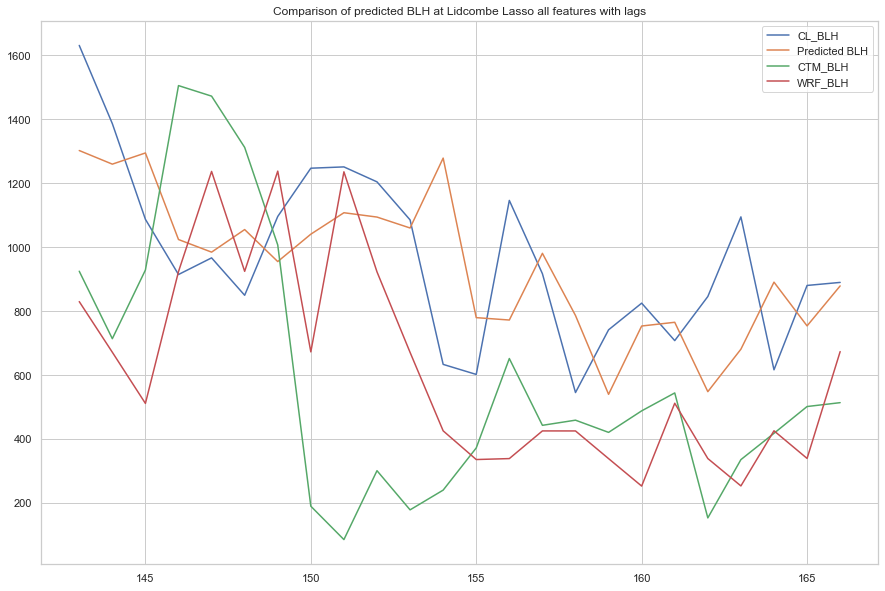

In [76]:
df_lasso_lidcombe_wlags, lasso_lidcombe_wlags = lasso_modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH') 
results_print(df_lasso_lidcombe_wlags, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Lasso all features with lags')

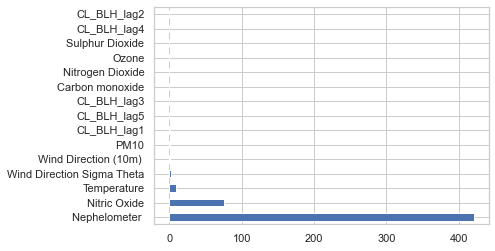

In [77]:
lasso_feature_importance_plot(lasso_lidcombe_wlags, feature_list_all_wlags)

## 3.6 Ridge regression 

In [78]:
from sklearn.linear_model import Ridge

In [79]:
def ridge_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    
    #Predict
    
    ridge_predict = ridge.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  ridge_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, ridge

In [80]:
#Finding the important features for Ridge regression
def ridge_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa Ridge all features with lags
Index of agreement:0.81945
Root mean squared error:202.37514
Mean absoluate error:174.43103
Mean bias error:160.81885
DTW distance:2535.37
MASE:0.92280


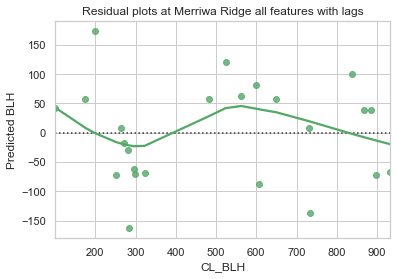

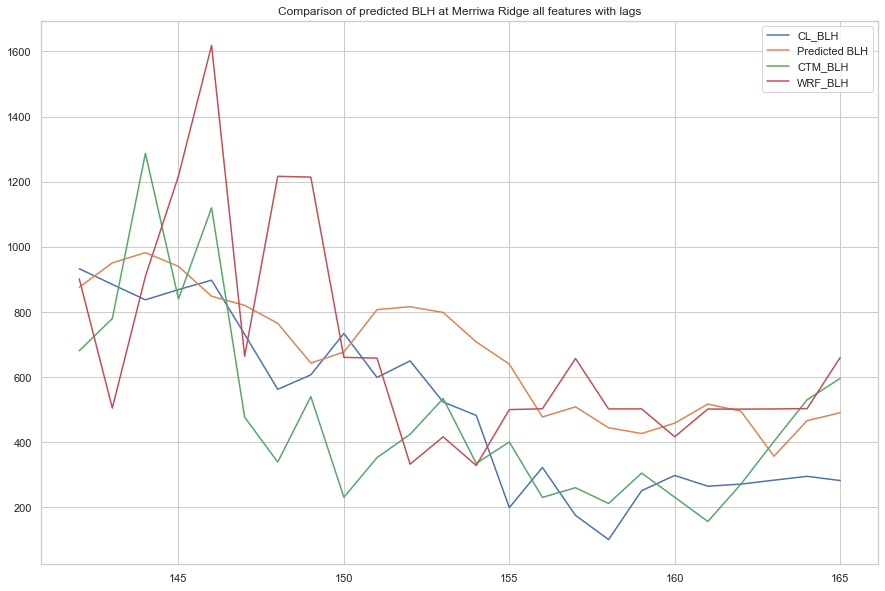

In [81]:
df_ridge_merriwa_wlags, ridge_merriwa_wlags = ridge_modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH')
results_print(df_ridge_merriwa_wlags, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Ridge all features with lags')

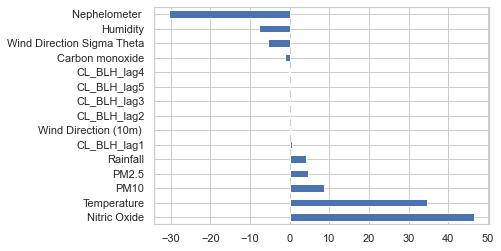

In [82]:
ridge_feature_importance_plot(ridge_merriwa_wlags, feature_list_all_wlags)

At Lidcombe Ridge all features with lags
Index of agreement:0.74737
Root mean squared error:233.03029
Mean absoluate error:186.66353
Mean bias error:-25.54786
DTW distance:2381.11
MASE:0.84868


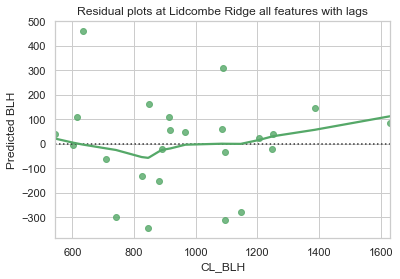

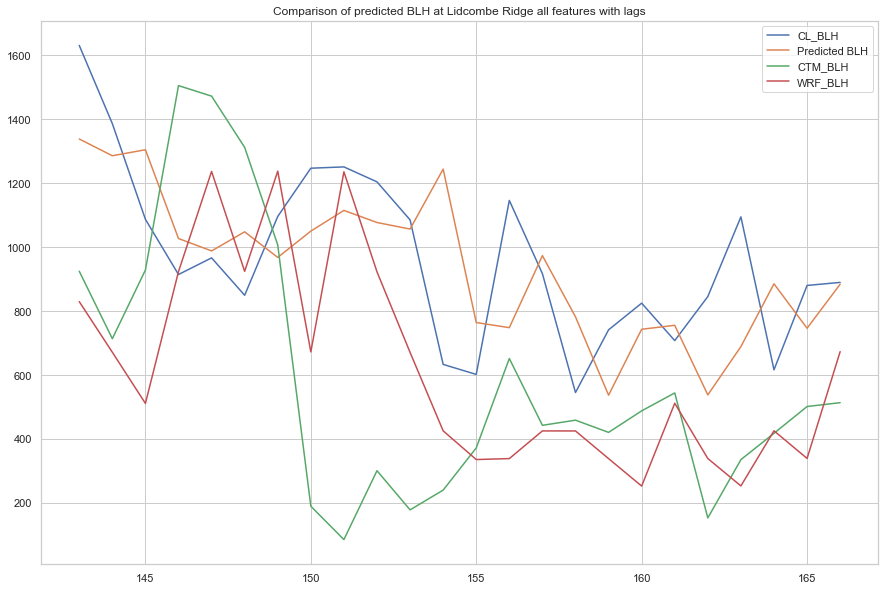

In [84]:
df_ridge_lidcombe_wlags, ridge_lidcombe_wlags = ridge_modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH') 
results_print(df_ridge_lidcombe_wlags, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Ridge all features with lags')

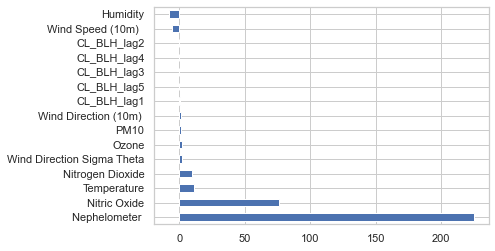

In [85]:
ridge_feature_importance_plot(ridge_lidcombe_wlags, feature_list_all_wlags)

## 3.7 Elastic Net

In [86]:
from sklearn.linear_model import ElasticNet

In [87]:
def enet_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    enet = ElasticNet()
    enet.fit(X_train, y_train)
    
    #Predict
    
    enet_predict = enet.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  enet_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, enet

In [88]:
#Finding the important features for ElasticNet regression
def enet_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa ElasticNet all features with lags
Index of agreement:0.86025
Root mean squared error:179.63360
Mean absoluate error:154.92911
Mean bias error:140.74616
DTW distance:2625.61
MASE:0.81963


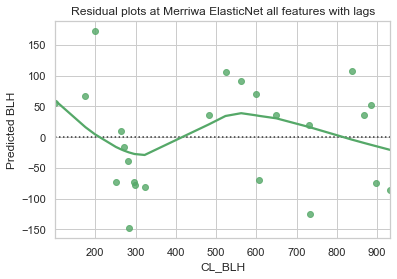

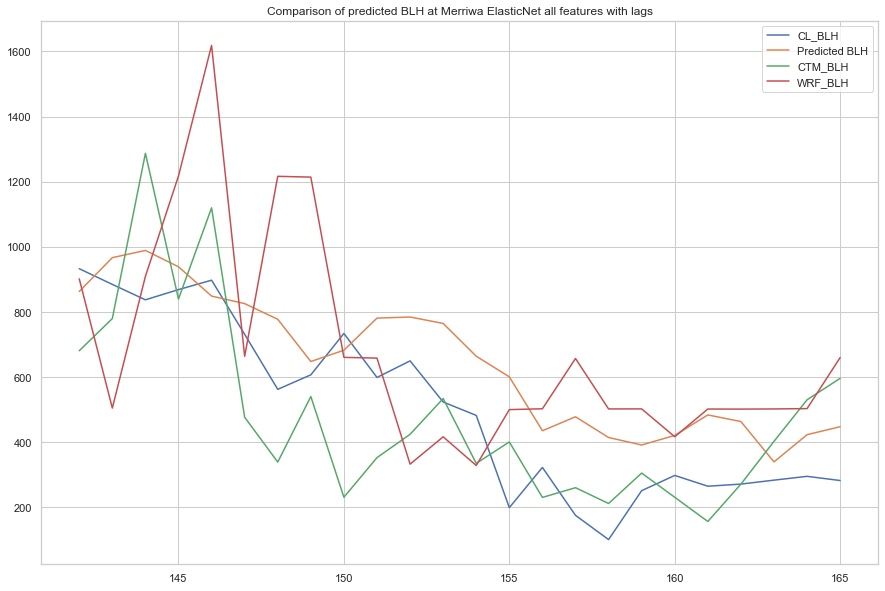

In [89]:
df_enet_merriwa_wlags, enet_merriwa_wlags = enet_modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH')
results_print(df_enet_merriwa_wlags, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa ElasticNet all features with lags')

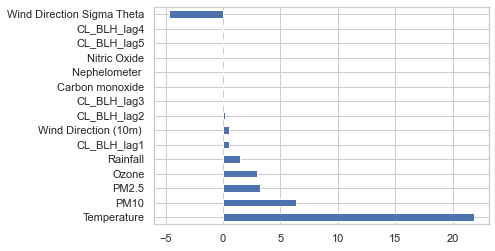

In [90]:
enet_feature_importance_plot(enet_merriwa_wlags, feature_list_all_wlags)

At Lidcombe ElasticNet all features with lags
Index of agreement:0.78184
Root mean squared error:222.86536
Mean absoluate error:181.31504
Mean bias error:-49.93686
DTW distance:2737.76
MASE:0.82436


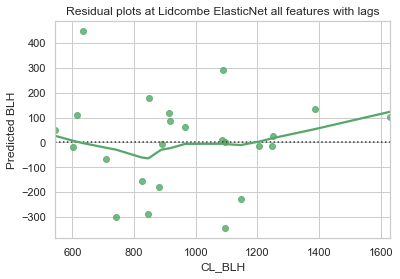

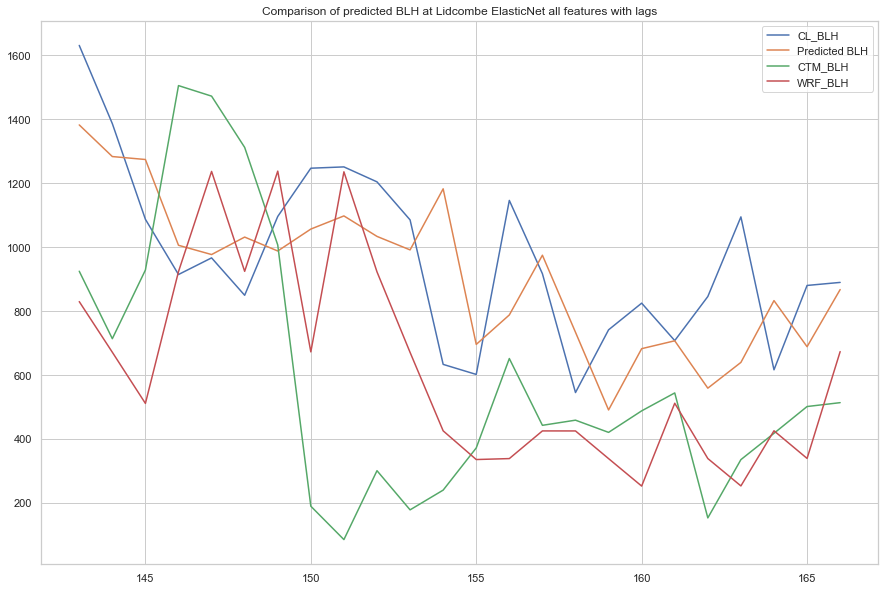

In [91]:
df_enet_lidcombe_wlags, enet_lidcombe_wlags = enet_modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH') 
results_print(df_enet_lidcombe_wlags, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe ElasticNet all features with lags')

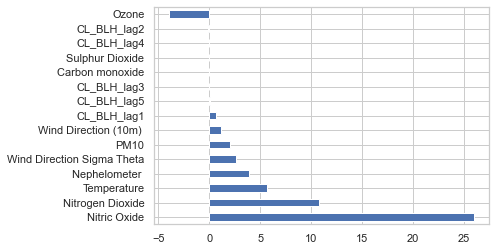

In [92]:
enet_feature_importance_plot(enet_lidcombe_wlags, feature_list_all_wlags)

# Notes

1. Different set of statistical metrics for different models

2. With different models comes different features which influence the model prediction. 

3. I have included R^2, but may not be necessary after discussion with group and settling on a particular set. 

4. Comparing models with IoA as the standard, Random forest seems to be the best fit for both Lidcombe and Merriwa, with SVR just a teeny bit ahead in Lidcombe. 

5. If to go with previous point, Random forest would be the way to go, would be compared with ARIMA and the neural net.

6. Interesting obs, LASSO is supposed to have higher accuracy than Ridge, but might not work here due to potential dropping of important features

7. ElasticNet seems to have the same IoA for both locations. Maybe this over RF for the battle with the other models.

8. Of course, hyperparameter tuning has to be done to find an optimal one. 